In [1]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import sys
import importlib
import random 
import pandas as pd
pd.options.mode.copy_on_write = True
import time
from os.path import join as pjoin
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 

In [2]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models

sys.path.append('../baseline/fins')

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)


2024-06-13 17:24:07.575841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 17:24:07.607792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 17:24:08.357623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'models' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/models.py'>

In [3]:
################## LOAD OUR DATASET  ##################

config=hlp.load_config("../config/basic.yaml")

# instantiate a test data set 
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/nonoise_48khz_guestxr.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)
# get one data sample 
sContent, sStyle, sTarget, sAnecho = dataset[128]


In [4]:
from nara_wpe.wpe import wpe,online_wpe_step, get_power_online, OnlineWPE
from nara_wpe.utils import stft, istft, get_stft_center_frequencies

def fit_nara(y):
    # grab all the nara params
    size = 512
    shift = 256
    taps = 10
    delay = 1
    alpha = 0.9999
    channel = 1
    frequency_bins = size // 2 + 1

    Y = stft(y.T, size=size, shift=shift).transpose(1, 2, 0)
    T, _, _ = Y.shape

    def aquire_framebuffer():
        # buffer init with zeros so output is time alligned
        buffer = list(np.zeros((taps + delay, Y.shape[1], Y.shape[2]), dtype=Y.dtype))
        # buffer = list(Y[: taps + delay, :, :])
        # for t in range(taps + delay + 1, T):

        for t in range(0, T):

            buffer.append(Y[t, :, :])
            yield np.array(buffer)
            buffer.pop(0)

    Z_list = []
    online_wpe = OnlineWPE(
        taps=taps,
        delay=delay,
        alpha=alpha,
        channel=channel,
        frequency_bins=frequency_bins,
    )
    
    for Y_step in aquire_framebuffer():
        Z_list.append(online_wpe.step_frame(Y_step))

    Z = np.stack(Z_list)
    z = istft(
        np.asarray(Z).transpose(2, 0, 1),
        size=size,
        shift=shift,
    )

    # return the output for the first channel
    return z[0], Y, Z

print(sContent.shape)
z, Y, Z=fit_nara(sContent.T.numpy())

Audio(z,rate=48000)

torch.Size([1, 98304])


In [11]:
def fit_nara(y):
    # grab all the nara params
    size = 512
    shift = 256
    taps = 10
    delay = 1
    alpha = 0.9999
    channel = 1
    frequency_bins = size // 2 + 1

    stft_options = dict(size=512, shift=128)
    Y = stft(y, **stft_options).transpose(2, 0, 1)
    T, _, _ = Y.shape

y=sContent.numpy()



Z = wpe(
    Y,
    taps=taps,
    delay=delay,
    iterations=iterations,
    statistics_mode='full'
).transpose(1, 2, 0)

z = istft(Z, size=stft_options['size'], shift=stft_options['shift'])

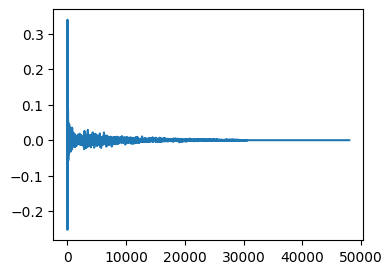

In [82]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 8))
im1 = ax1.imshow(20 * np.log10(np.abs(Y[200:400, :, 0])).T, origin='lower')
ax1.set_xlabel('')
_ = ax1.set_title('reverberated')
im2 = ax2.imshow(20 * np.log10(np.abs(Z[200:400, :, 0])).T, origin='lower')
_ = ax2.set_title('dereverberated')